In [335]:
import warnings

In [336]:
warnings.filterwarnings("ignore")

In [337]:
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt
from statsmodels.tsa.ar_model import AutoReg

In [338]:
data = pd.read_csv("../NullValueHandled/ColomboProperHandledNullValues.csv", index_col=0, parse_dates=True)

In [339]:
data.head()

,Next Date,HCHO reading
Current Date,,
2019-01-01,2019-01-02,0.000197
2019-01-02,2019-01-03,0.000263
2019-01-03,2019-01-04,0.000099
2019-01-04,2019-01-05,0.000210
2019-01-05,2019-01-06,0.000179


In [340]:
colombo_data = data[["HCHO reading"]]
colombo_data.head()

,HCHO reading
Current Date,
2019-01-01,0.000197
2019-01-02,0.000263
2019-01-03,0.000099
2019-01-04,0.000210
2019-01-05,0.000179


In [341]:
colombo_data.shape

(1826, 1)

In [342]:
X = colombo_data.values

#### This looks like that colombo fomaldihyde rates have a seasonality

<Axes: xlabel='Current Date'>

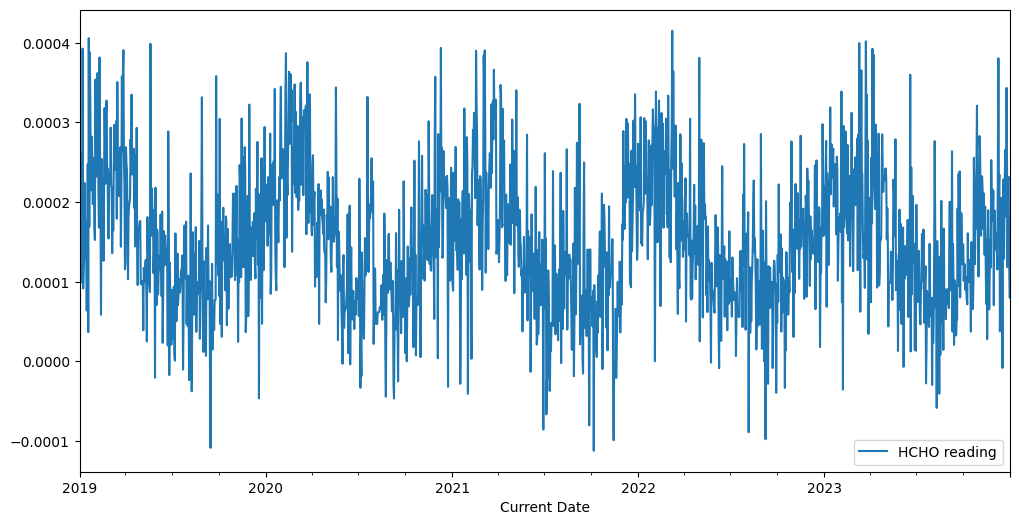

In [343]:
colombo_data.plot(figsize=(12, 6))

In [344]:
from statsmodels.tsa.stattools import adfuller

In [345]:
test_colombo = adfuller(colombo_data["HCHO reading"], autolag="AIC")

In [346]:
print("ADF value : ", test_colombo[0])
print("P value: ", test_colombo[1])
print("Num of Lags :", test_colombo[2])
print("Num of Observations used for ADF Regression and Critical Calculation :", test_colombo[3])
for key, val in test_colombo[4].items():
    print("\t", key, ": ", val)

ADF value :  -3.8828939837504732
P value:  0.0021644075534644367
Num of Lags : 16
Num of Observations used for ADF Regression and Critical Calculation : 1809
	 1% :  -3.4339700129534423
	 5% :  -2.8631390341376393
	 10% :  -2.567621272963846


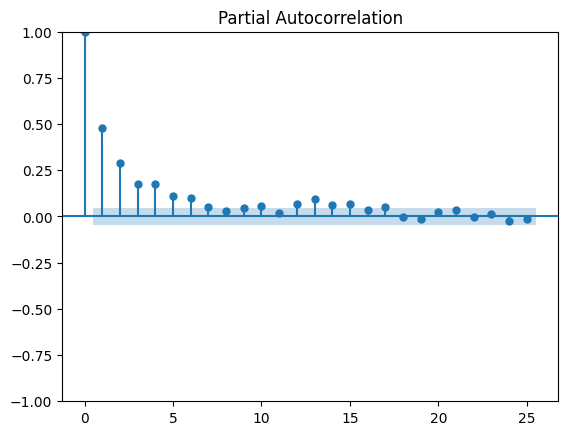

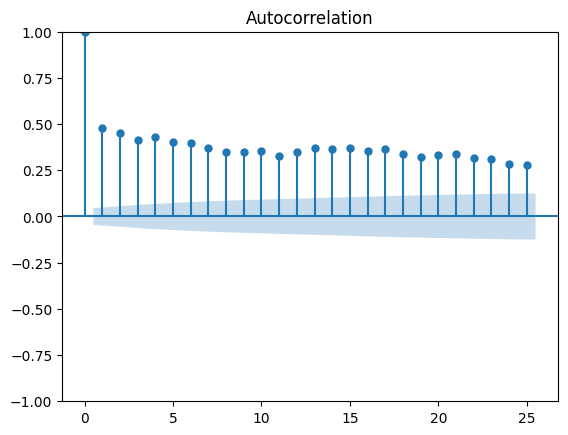

In [347]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

pacf = plot_pacf(colombo_data["HCHO reading"], lags=25)
acf = plot_acf(colombo_data["HCHO reading"], lags=25) 

#### This Autocorrelation and Partial correlation plots show that there is a seasonality in colombo region data
#### Howevever, it is not stationary, Therefore MA,Auto Regression and ARIMA models does not support for this.

In [348]:
(1826 / 100) * 80

1460.8000000000002

In [349]:
train=X[:1600]
test=X[1600:]

In [350]:
train[:5]

array([[1.96983440e-04],
       [2.62552217e-04],
       [9.85211890e-05],
       [2.09932052e-04],
       [1.78533730e-04]])

#### Based on the partial correlation plot, given 7 as the lag

In [356]:
# Import necessary libraries
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.api import AutoReg

# Assuming train is already defined as a numpy array

# Define the scaler
scaler = MinMaxScaler()

# Fit the scaler to the training data and transform it
scaler.fit(train.reshape(-1, 1))
train_normalized = scaler.transform(train.reshape(-1, 1))

# Convert the normalized data back to a numpy array
train_normalized = train_normalized.flatten()

# Train the AutoReg model
model = AutoReg(train_normalized, lags=20).fit()


In [357]:
print(model.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                 1600
Model:                    AutoReg(20)   Log Likelihood                 993.402
Method:               Conditional MLE   S.D. of innovations              0.129
Date:                Sun, 07 Apr 2024   AIC                          -1942.805
Time:                        13:04:03   BIC                          -1824.771
Sample:                            20   HQIC                         -1898.947
                                 1600                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0522      0.015      3.425      0.001       0.022       0.082
y.L1           0.2135      0.025      8.489      0.000       0.164       0.263
y.L2           0.1197      0.026      4.679      0.0

In [358]:
# Make predictions using the trained model
predicted_normalized = model.predict(start=len(train_normalized), end=len(train_normalized) + len(test) - 1, dynamic=False)

# Inverse transform the predicted values to the original scale
predicted_values = scaler.inverse_transform(predicted_normalized.reshape(-1, 1)).flatten()

# Create a DataFrame for predicted values
predicted_df = pd.DataFrame(predicted_values, columns=['predicted'])

test = pd.DataFrame(test)
# Set the index of the predicted DataFrame to match the test data index
predicted_df.index = test.index

# Add the actual values from the test set to the DataFrame
predicted_df['actual'] = test

# Display the DataFrame with predicted and actual values
print(predicted_df.head())

   predicted    actual
0   0.000157  0.000157
1   0.000154  0.000279
2   0.000153  0.000089
3   0.000153  0.000097
4   0.000141  0.000106


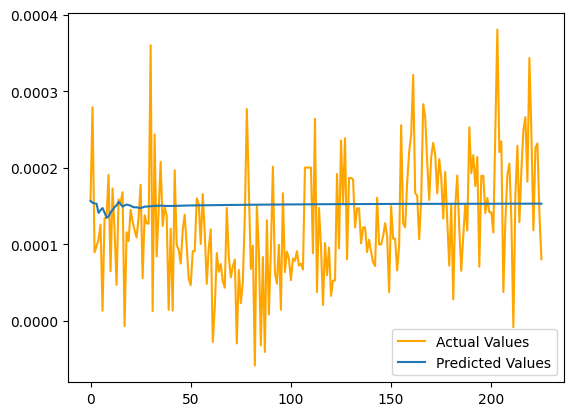

In [359]:
from matplotlib import pyplot

pyplot.plot(test, color="orange", label='Actual Values')
pyplot.plot(predicted_values, label='Predicted Values')
pyplot.legend()

In [360]:
from tabulate import tabulate
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, explained_variance_score

# Assuming you have your test and predicted values stored in 'test' and 'predicted_values' variables

# Calculate the metrics
r_squared = r2_score(test, predicted_values)
mae = mean_absolute_error(test, predicted_values)
mse = mean_squared_error(test, predicted_values)
rmse = mean_squared_error(test, predicted_values, squared=False)
median_absolute = median_absolute_error(test, predicted_values)
explained_variance = explained_variance_score(test, predicted_values)

table_headers = ["Metric", "Value"]
table_data = {
    "R-squared (Coefficient of Determination)": "{:.12f}".format(r_squared),
    "Mean Absolute Error (MAE)": "{:.12f}".format(mae),
    "Mean Squared Error (MSE)": "{:.12f}".format(mse),
    "Root Mean Squared Error (RMSE)": "{:.12f}".format(rmse),
    "Median Absolute Error": "{:.12f}".format(median_absolute),
    "Explained Variance Score": "{:.12f}".format(explained_variance)
}

# Create DataFrame
df = pd.DataFrame(table_data.items(), columns=table_headers)

df

,Metric,Value
0,R-squared (Coefficient of Determination),-0.085211920301
1,Mean Absolute Error (MAE),0.000061620280
2,Mean Squared Error (MSE),0.000000005905
3,Root Mean Squared Error (RMSE),0.000076846032
4,Median Absolute Error,0.000054469953
5,Explained Variance Score,0.006918712994


#### This shows that above model does not perform well with the R2 score

### Check moving average on the colombo data

In [361]:
colombo_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2019-01-01 to 2023-12-31
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HCHO reading  1826 non-null   float64
dtypes: float64(1)
memory usage: 28.5 KB


In [362]:
from statsmodels.tsa.arima.model import ARIMA

# Define the scaler
scaler = MinMaxScaler()

train = pd.DataFrame(train) 

# Fit the scaler to the training data and transform it
scaler.fit(train[[0]])
train_normalized = scaler.transform(train[[0]])

# Convert the normalized data back to a numpy array
train_normalized = train_normalized.flatten()

arima_model = ARIMA(train_normalized, order=(0, 0, 25))
arima_model = arima_model.fit()
arima_model.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1600
Model:                ARIMA(0, 0, 25)   Log Likelihood                 978.386
Date:                Sun, 07 Apr 2024   AIC                          -1902.772
Time:                        13:04:37   BIC                          -1757.573
Sample:                             0   HQIC                         -1848.855
                               - 1600                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5060      0.014     36.009      0.000       0.478       0.534
ma.L1          0.2222      0.025      8.951      0.000       0.174       0.271
ma.L2          0.1897      0.025      7.634      0.000       0.141       0.238
ma.L3          0.1528      0.027      5.665      0.000       0.100       0.206
ma.L4          0.2034      0.027      7.406      0.000       0.150       0.257
ma.L5          0.1634      0.029      5.729      0.000       0.107       0.219
ma.L6          0.1951      0.028      6.897      0.000       0.140       0.251
ma.L7          0.1504      0.028      5.455      0.000       0.096       0.204
ma.L8          0.1252      0.028      4.434      0.000       0.070       0.181
ma.L9          0.1400      0.028      4.954      0.000       0.085       0.195
ma.L10         0.1165      0.029      3.961      0.000       0.059       0.174
ma.L11         0.0681      0.027      2.512      0.012       0.015       0.121
ma.L12         0.0950      0.027      3.474      0.001       0.041       0.149
ma.L13         0.1317      0.028      4.735      0.000       0.077       0.186
ma.L14         0.1217      0.029      4.227      0.000       0.065       0.178
ma.L15         0.1497      0.027      5.526      0.000       0.097       0.203
ma.L16         0.1091      0.028      3.912      0.000       0.054       0.164
ma.L17         0.1642      0.029      5.650      0.000       0.107       0.221
ma.L18         0.0849      0.029      2.974      0.003       0.029       0.141
ma.L19         0.0882      0.028      3.132      0.002       0.033       0.143
ma.L20         0.0964      0.029      3.370      0.001       0.040       0.152
ma.L21         0.1199      0.029      4.155      0.000       0.063       0.176
ma.L22         0.0854      0.028      3.060      0.002       0.031       0.140
ma.L23         0.1064      0.028      3.799      0.000       0.052       0.161
ma.L24         0.0260      0.025      1.026      0.305      -0.024       0.076
ma.L25         0.0438      0.025      1.732      0.083      -0.006       0.093
sigma2         0.0172      0.001     33.836      0.000       0.016       0.018
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                96.05
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.98   Skew:                             0.15
Prob(H) (two-sided):                  0.78   Kurtosis:                         4.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [363]:
start = len(train)
end = len(train) + len(test) - 1
predicted_values = pd.DataFrame(scaler.inverse_transform(arima_model.predict(start=start, end=end, type="levels").reshape(-1, 1)))
predicted_values.index = colombo_data.index[start:end + 1]

In [364]:
predicted_values.head()

,0
Current Date,
2023-05-20,0.000149
2023-05-21,0.000146
2023-05-22,0.000144
2023-05-23,0.000149
2023-05-24,0.000134


In [365]:
predicted_values.rename(columns={0:"predicted"}, inplace=True)

In [366]:
predicted_values["actual"] = test[0].values

In [367]:
predicted_values.head()

,predicted,actual
Current Date,,
2023-05-20,0.000149,0.000157
2023-05-21,0.000146,0.000279
2023-05-22,0.000144,0.000089
2023-05-23,0.000149,0.000097
2023-05-24,0.000134,0.000106


<Axes: xlabel='Current Date'>

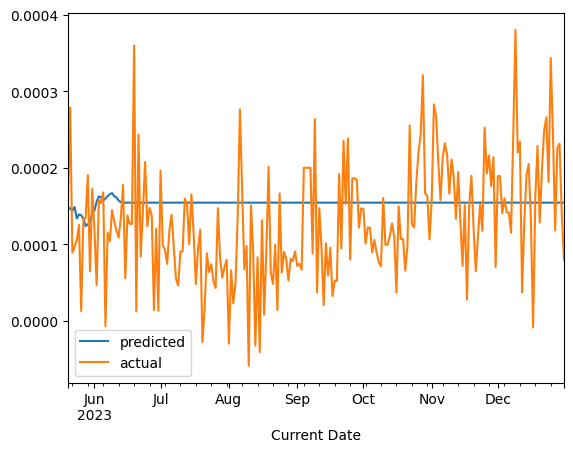

In [368]:
predicted_values.plot(legend=True)

In [369]:
from tabulate import tabulate
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, explained_variance_score

# Assuming you have your test and predicted values stored in 'test' and 'predicted_values' variables

predicted_values = predicted_values["predicted"]

# Calculate the metrics
r_squared = r2_score(test, predicted_values)
mae = mean_absolute_error(test, predicted_values)
mse = mean_squared_error(test, predicted_values)
rmse = mean_squared_error(test, predicted_values, squared=False)
median_absolute = median_absolute_error(test, predicted_values)
explained_variance = explained_variance_score(test, predicted_values)

table_headers = ["Metric", "Value"]
table_data = {
    "R-squared (Coefficient of Determination)": "{:.12f}".format(r_squared),
    "Mean Absolute Error (MAE)": "{:.12f}".format(mae),
    "Mean Squared Error (MSE)": "{:.12f}".format(mse),
    "Root Mean Squared Error (RMSE)": "{:.12f}".format(rmse),
    "Median Absolute Error": "{:.12f}".format(median_absolute),
    "Explained Variance Score": "{:.12f}".format(explained_variance)
}

# Create DataFrame
df = pd.DataFrame(table_data.items(), columns=table_headers)

df

,Metric,Value
0,R-squared (Coefficient of Determination),-0.117303919037
1,Mean Absolute Error (MAE),0.000062956162
2,Mean Squared Error (MSE),0.000000006080
3,Root Mean Squared Error (RMSE),0.000077974003
4,Median Absolute Error,0.000055959691
5,Explained Variance Score,-0.003659932651


#### Check SARIMA Model

In [370]:
from sklearn.preprocessing import MinMaxScaler

# Define the scaler
scaler = MinMaxScaler()

# Fit the scaler to the training data and transform it
train_normalized = scaler.fit_transform(train.values.reshape(-1, 1))

# Convert the normalized data back to a pandas Series
train_normalized = pd.Series(train_normalized.flatten(), index=train.index)


from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define the SARIMA model
sarima_model = SARIMAX(train_normalized, order=(20, 0, 4), seasonal_order=(0, 1, 1, 12))

# Fit the SARIMA model
sarima_result = sarima_model.fit()

# Print the summary of the SARIMA model
print(sarima_result.summary())

                                       SARIMAX Results                                       
Dep. Variable:                                     y   No. Observations:                 1600
Model:             SARIMAX(20, 0, 4)x(0, 1, [1], 12)   Log Likelihood                 955.848
Date:                               Sun, 07 Apr 2024   AIC                          -1859.695
Time:                                       13:05:32   BIC                          -1720.069
Sample:                                            0   HQIC                         -1807.828
                                              - 1600                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0637      2.872      0.022      0.982      -5.565       5.693
ar.L2      

In [371]:
colombo_data.shape

(1826, 1)

In [372]:
import numpy as np

# Extract predicted values
predicted_values = sarima_result.get_prediction(start=start, end=end, dynamic=False).predicted_mean

# Convert predicted values to numpy array
predicted_values_array = np.array(predicted_values)

# Reshape predicted_values to 2D array as expected by inverse_transform
predicted_values_array = predicted_values_array.reshape(-1, 1)

# Inverse transform the predicted values
predicted_values = scaler.inverse_transform(predicted_values_array)

# Create DataFrame for Predictions
predicted_df = pd.DataFrame({'predicted': predicted_values.flatten(), 'actual': test[0].values}, index=test.index)

predicted_df.head()

,predicted,actual
0,0.000151,0.000157
1,0.000142,0.000279
2,0.000149,0.000089
3,0.000151,0.000097
4,0.000148,0.000106


In [374]:
from tabulate import tabulate
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, explained_variance_score

# Assuming you have your test and predicted values stored in 'test' and 'predicted_values' variables

predicted_values = predicted_df["predicted"]

# Calculate the metrics
r_squared = r2_score(test, predicted_values)
mae = mean_absolute_error(test, predicted_values)
mse = mean_squared_error(test, predicted_values)
rmse = mean_squared_error(test, predicted_values, squared=False)
median_absolute = median_absolute_error(test, predicted_values)
explained_variance = explained_variance_score(test, predicted_values)

table_headers = ["Metric", "Value"]
table_data = {
    "R-squared (Coefficient of Determination)": "{:.12f}".format(r_squared),
    "Mean Absolute Error (MAE)": "{:.12f}".format(mae),
    "Mean Squared Error (MSE)": "{:.12f}".format(mse),
    "Root Mean Squared Error (RMSE)": "{:.12f}".format(rmse),
    "Median Absolute Error": "{:.12f}".format(median_absolute),
    "Explained Variance Score": "{:.12f}".format(explained_variance)
}

# Create DataFrame
df = pd.DataFrame(table_data.items(), columns=table_headers)

df

,Metric,Value
0,R-squared (Coefficient of Determination),-0.097994377621
1,Mean Absolute Error (MAE),0.000062221412
2,Mean Squared Error (MSE),0.000000005975
3,Root Mean Squared Error (RMSE),0.000077297283
4,Median Absolute Error,0.000056130561
5,Explained Variance Score,0.005331958334


<Axes: >

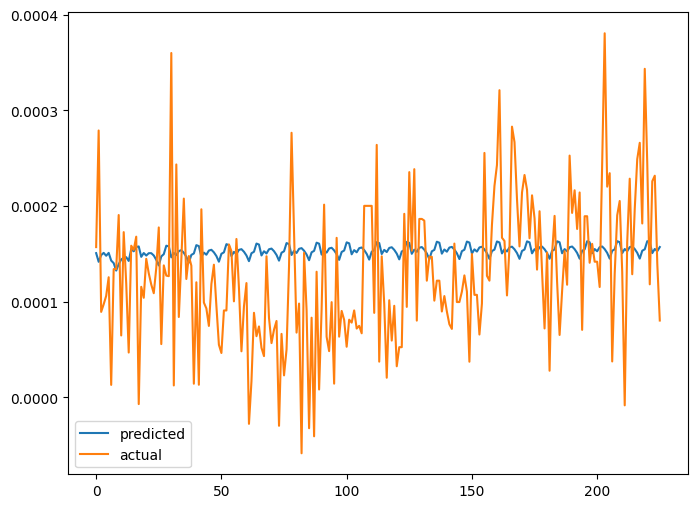

In [373]:
predicted_df.plot(legend=True, figsize=(8, 6))

#### It shows that these models do not support well, therefore tried with deep learning techniques

#### Using LSTM Model 

In [324]:
data = pd.read_csv("../NullValueHandled/ColomboProperHandledNullValues.csv", parse_dates=True)
data.drop(columns=["Next Date"], inplace=True)

In [325]:
print(data.head())

  Current Date  HCHO reading
0   2019-01-01      0.000197
1   2019-01-02      0.000263
2   2019-01-03      0.000099
3   2019-01-04      0.000210
4   2019-01-05      0.000179


In [326]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop

# Assuming 'data' is your DataFrame and you've loaded it successfully

# Preprocess data
data['Current Date'] = pd.to_datetime(data['Current Date'])
data.sort_values(by='Current Date', inplace=True)
data.set_index('Current Date', inplace=True)

# Split data into train and test sets
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# Define function to create sequences for RNN
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length, -1])  # Assuming target is the last column
    return np.array(X), np.array(y)

sequence_length = 2 # Adjust sequence length as necessary

# Create sequences for training and testing data
X_train, y_train = create_sequences(train_scaled, sequence_length)
X_test, y_test = create_sequences(test_scaled, sequence_length)

# Enhanced model with additional Bidirectional LSTM layers and Dropout layers
model = Sequential([
    Bidirectional(LSTM(units=1000, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    Bidirectional(LSTM(units=500, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    Bidirectional(LSTM(units=400, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    Bidirectional(LSTM(units=250, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(units=125, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(units=50, return_sequences=False)),
    Dropout(0.3),
    Dense(units=1)
])

optimizer = RMSprop(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])

# Early stopping to monitor the loss and prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=20, mode='min', restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/20
37/37 [==============================] - 43s 393ms/step - loss: 0.0762 - mean_squared_error: 0.0762 - val_loss: 0.0171 - val_mean_squared_error: 0.0171
Epoch 2/20
37/37 [==============================] - 7s 192ms/step - loss: 0.0326 - mean_squared_error: 0.0326 - val_loss: 0.0214 - val_mean_squared_error: 0.0214
Epoch 3/20
37/37 [==============================] - 7s 184ms/step - loss: 0.0318 - mean_squared_error: 0.0318 - val_loss: 0.0175 - val_mean_squared_error: 0.0175
Epoch 4/20
37/37 [==============================] - 7s 185ms/step - loss: 0.0325 - mean_squared_error: 0.0325 - val_loss: 0.0167 - val_mean_squared_error: 0.0167
Epoch 5/20
37/37 [==============================] - 7s 183ms/step - loss: 0.0320 - mean_squared_error: 0.0320 - val_loss: 0.0240 - val_mean_squared_error: 0.0240
Epoch 6/20
37/37 [==============================] - 7s 183ms/step - loss: 0.0311 - mean_squared_error: 0.0311 - val_loss: 0.0212 - val_mean_squared_error: 0.0212
Epoch 7/20
37/37 [=========

12/12 [==============================] - 7s 31ms/step


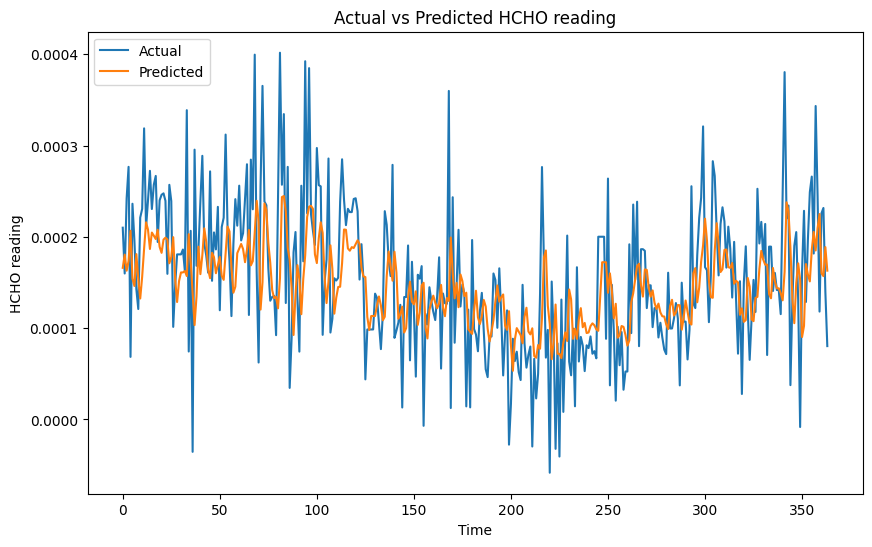

In [327]:
import matplotlib.pyplot as plt

# Predict values for testing data
predictions_scaled = model.predict(X_test)

# Inverse transform predictions and actual values to original scale
predictions = scaler.inverse_transform(predictions_scaled)
actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(actual, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('HCHO reading')
plt.title('Actual vs Predicted HCHO reading')
plt.legend()
plt.show()

46/46 [==============================] - 2s 37ms/step


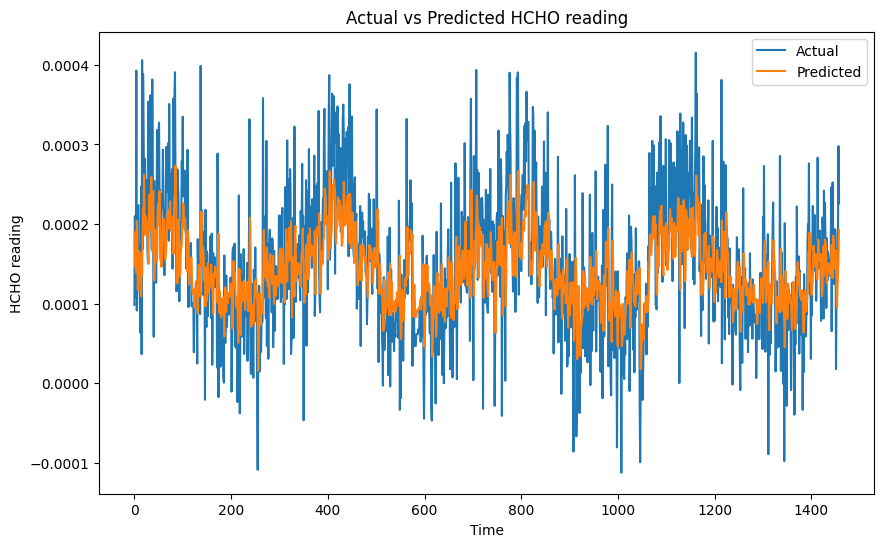

In [328]:
import matplotlib.pyplot as plt

# Predict values for testing data
predictions_scaled = model.predict(X_train)

# Inverse transform predictions and actual values to original scale
predictions = scaler.inverse_transform(predictions_scaled)
actual = scaler.inverse_transform(y_train.reshape(-1, 1))

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(actual, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('HCHO reading')
plt.title('Actual vs Predicted HCHO reading')
plt.legend()
plt.show()

46/46 [==============================] - 2s 33ms/step


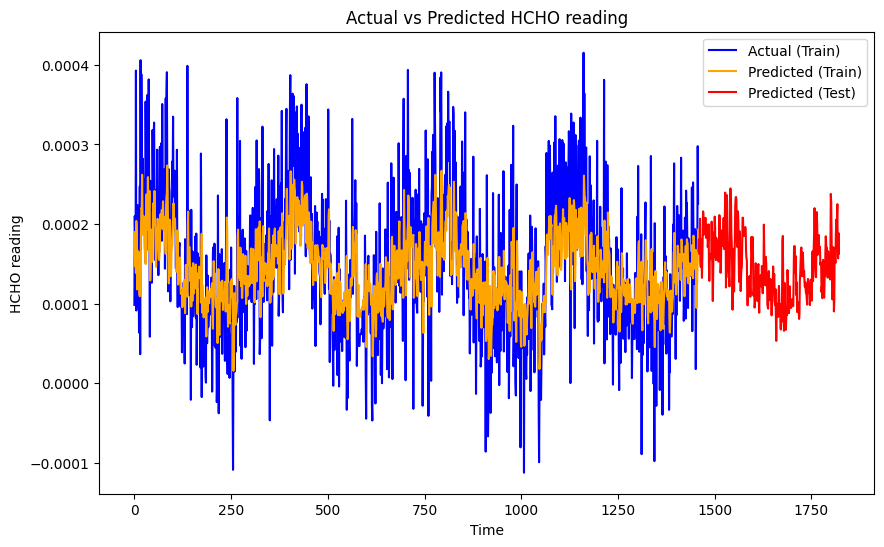

In [329]:
import matplotlib.pyplot as plt

# Predict values for testing data
predictions_scaled_test = model.predict(X_test)

# Inverse transform predictions and actual values to original scale for testing data
predictions_test = scaler.inverse_transform(predictions_scaled_test)
actual_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Predict values for training data
predictions_scaled_train = model.predict(X_train)

# Inverse transform predictions and actual values to original scale for training data
predictions_train = scaler.inverse_transform(predictions_scaled_train)
actual_train = scaler.inverse_transform(y_train.reshape(-1, 1))

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(actual_train, label='Actual (Train)', color='blue')
plt.plot(predictions_train, label='Predicted (Train)', color='orange')
plt.plot(len(predictions_train) + np.arange(len(predictions_test)), predictions_test, label='Predicted (Test)', color='red')
plt.xlabel('Time')
plt.ylabel('HCHO reading')
plt.title('Actual vs Predicted HCHO reading')
plt.legend()
plt.show()

In [330]:
y_test = actual
predicted_values = predictions.reshape(-1, 1)
r2 = r2_score(y_test, predicted_values)
mae = mean_absolute_error(y_test, predicted_values)
mse = mean_squared_error(y_test, predicted_values)
rmse = mean_squared_error(y_test, predicted_values, squared=False)
median_absolute = median_absolute_error(y_test, predicted_values)
explained_variance = explained_variance_score(y_test, predicted_values)

# Print evaluation metrics
print(f"R-squared (Coefficient of Determination): {r2}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Median Absolute Error: {median_absolute}")
print(f"Explained Variance Score: {explained_variance}")

R-squared (Coefficient of Determination): 0.3002548518155087
Mean Absolute Error (MAE): 5.504993060707693e-05
Mean Squared Error (MSE): 5.3577823342430605e-09
Root Mean Squared Error (RMSE): 7.319687380102418e-05
Median Absolute Error: 3.991052018928638e-05
Explained Variance Score: 0.3067015527212714


#### Using Facebook Prophet Model

12:58:17 - cmdstanpy - INFO - Chain [1] start processing
12:58:17 - cmdstanpy - INFO - Chain [1] done processing


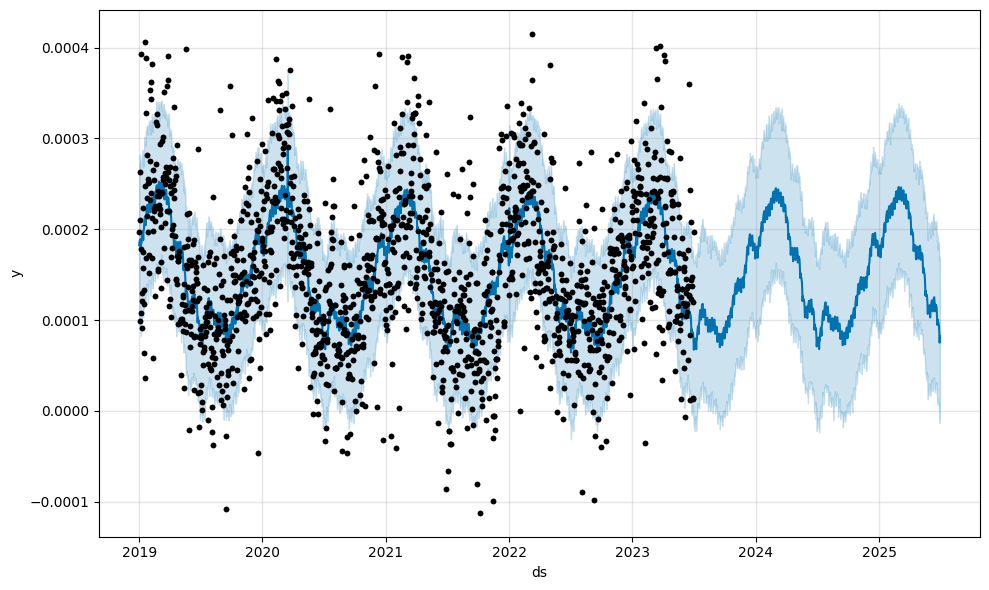

In [331]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

# Load and prepare your data
data = pd.read_csv("../NullValueHandled/ColomboProperHandledNullValues.csv", parse_dates=True)
data.drop(columns=["Next Date"], inplace=True)
data.rename(columns={'Current Date': 'ds', 'HCHO reading': 'y'}, inplace=True)
data['ds'] = pd.to_datetime(data['ds'])

# Define holidays
holidays = pd.DataFrame({
    'holiday': 'holiday_name',
    'ds': pd.to_datetime(['2020-03-15', '2021-12-31']), 
    'lower_window': 0,
    'upper_window': 1,
})

train_size = int(0.90 * len(data)) 
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Initialize and fit the Prophet model with holidays
model = Prophet(holidays=holidays) 
model.fit(train_data)

# Create a dataframe for future dates predictions
future = model.make_future_dataframe(periods=730)

# Make predictions
forecast = model.predict(future)

# Plot the forecast
fig1 = model.plot(forecast)
ax = fig1.gca()

# Overlay actual data
ax.plot(train_data['ds'], train_data['y'], 'k.', label='Actual Data')

plt.show()


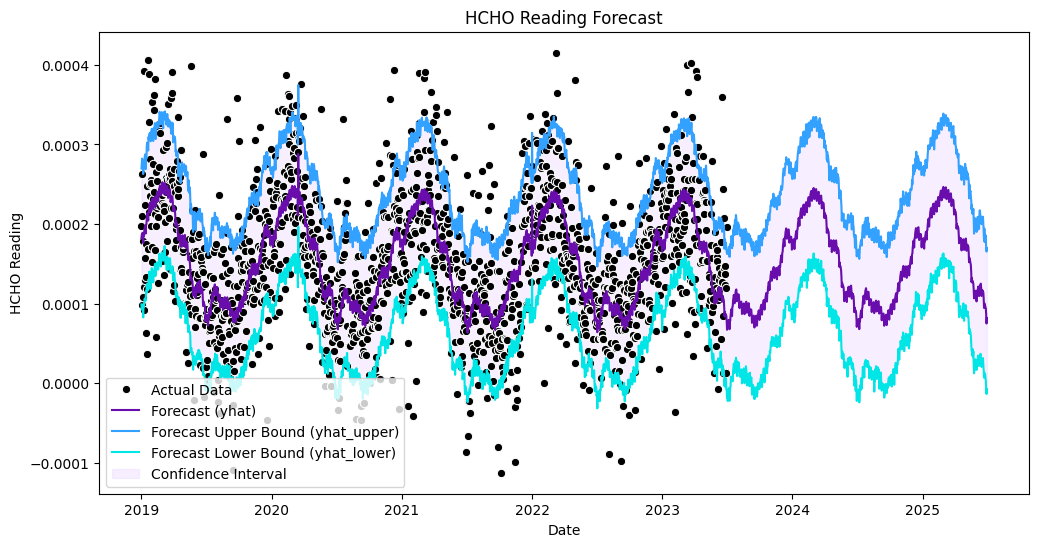

In [332]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot actual data
sns.lineplot(data=train_data, x='ds', y='y', label='Actual Data', color='black', marker='o', linestyle='None')

# Plot yhat - forecast
sns.lineplot(data=forecast, x='ds', y='yhat', label='Forecast (yhat)', color='#6a0dad')  # Purple

# Plot yhat_upper
sns.lineplot(data=forecast, x='ds', y='yhat_upper', label='Forecast Upper Bound (yhat_upper)', color='#33a1ff')  # Teal

# Plot yhat_lower
sns.lineplot(data=forecast, x='ds', y='yhat_lower', label='Forecast Lower Bound (yhat_lower)', color='#00e6e6')  # Light Teal

plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='#d9b3ff', alpha=0.2, label='Confidence Interval')  # Light Purple

plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.title('HCHO Reading Forecast')

# Adjust legend
plt.legend()

plt.show()

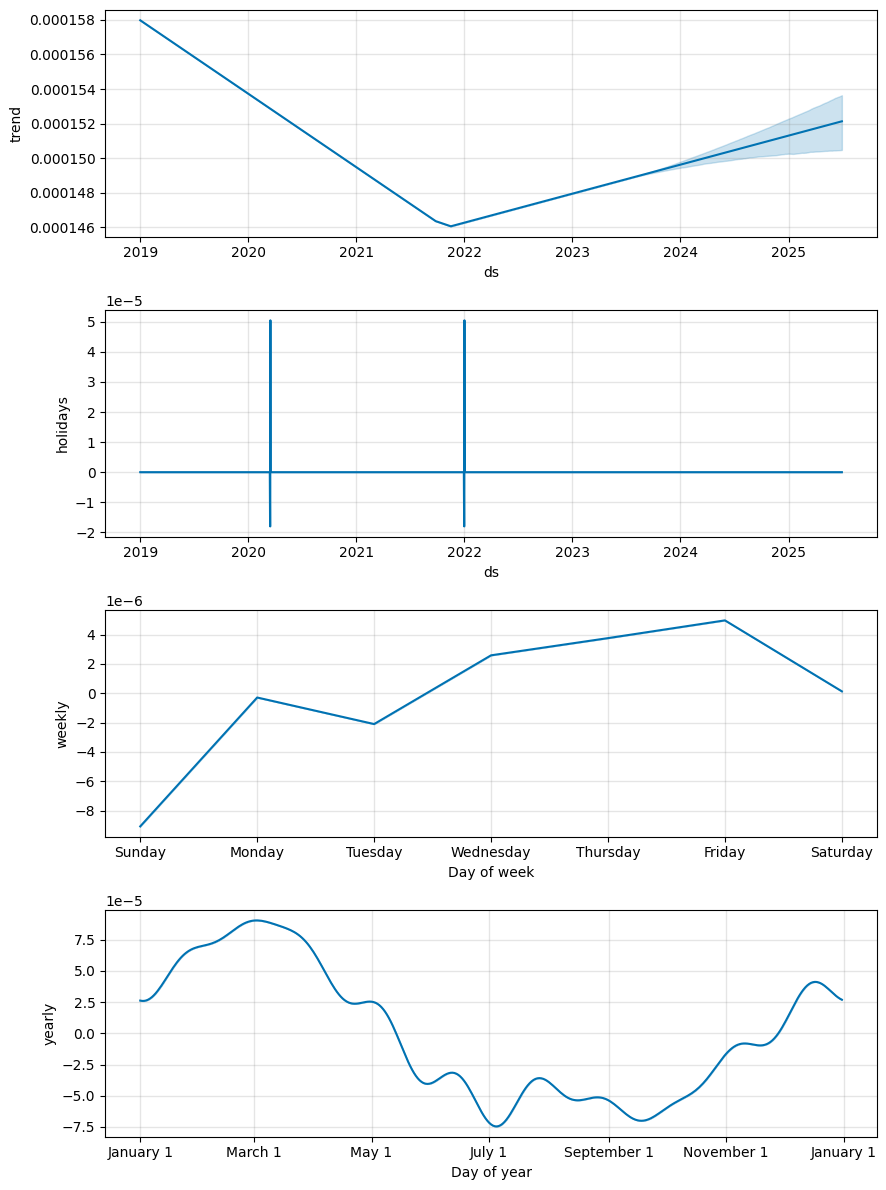

In [333]:
# Plot the forecast components
fig2 = model.plot_components(forecast)

In [334]:
y_test = test_data['y']
predicted_values = forecast.loc[forecast['ds'].isin(test_data['ds']), 'yhat']  # Extract forecasted values for test period
r2 = r2_score(y_test, predicted_values)
mae = mean_absolute_error(y_test, predicted_values)
mse = mean_squared_error(y_test, predicted_values)
rmse = mean_squared_error(y_test, predicted_values, squared=False)
median_absolute = median_absolute_error(y_test, predicted_values)
explained_variance = explained_variance_score(y_test, predicted_values)

# Print evaluation metrics
print(f"R-squared (Coefficient of Determination): {r2}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Median Absolute Error: {median_absolute}")
print(f"Explained Variance Score: {explained_variance}")

R-squared (Coefficient of Determination): 0.14356233804367868
Mean Absolute Error (MAE): 5.222868685153935e-05
Mean Squared Error (MSE): 4.78416822731191e-09
Root Mean Squared Error (RMSE): 6.916768195705209e-05
Median Absolute Error: 3.854897335530504e-05
Explained Variance Score: 0.16883338051227148
